In [1]:
# notebook dedicated to computing various intrinsic metrics to see whether 
# they corresond to downstream performance and could be useful for RLHF

In [1]:
from transformers import AutoTokenizer
import pandas as pd
from rlhfutils.eval_utils import getapfsft, tok_dist
import matplotlib.pyplot as plt
from rlhfutils.debug_utils import load_rm, progress_rm, load_all_rmdfs, load_all_hackdfs, highlight_differences
from statistics import mean, stdev, median
from scipy.stats import pearsonr, kendalltau, spearmanr
import math
from rouge_score import rouge_scorer
import seaborn as sns
import numpy as np
from matplotlib.colors import LogNorm


/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-11-14 15:45:25,370] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# replace all wgptouts with corresponding stack QA format (RM input format)
def setall(l):
    newl = []
    try:
        for ind in l:
            newl.append(getapfsft(ind, True))
            #print(0)
    except:
        return None
    return newl

def splitall(l):
    try: 
        return [s.split("Answer:")[1] for s in l]
    except:
        return None

def getfulldist(lcol):
    hist = []
    for l in lcol:
        hist.extend(l)
    return hist

def compdist(lcol, slen):
    res = []
    tmp = []
    for i in range(len(lcol)):
        tmp.append(lcol[i])
        if len(tmp)%slen==0:
            res.append(tmp)
            tmp = []
    return res
    
def procall(indf, toker, needset=True):
    if needset:
        indf['response'] = [setall(s) for s in indf['response']]
    indf = indf.dropna()
    indf['answers'] = [splitall(s) for s in indf['response']]
    indf = indf.dropna()
    indf['atoks'] = [tok_dist(s, wgtok) for s in list(indf['answers'])]
    indf['ttoks'] = [tok_dist(s, wgtok) for s in list(indf['response'])]
    return indf

# take rouge between all pairs. High rouge should bigger gaps
def rpaircorr(row, scat=False):
    rouges = []
    diffs = []
    for i in range(len(row)):
        for j in range(i, len(row)):
            if i==j:
                continue
            trmp = scorer.score(row['answers'][i], row['answers'][j])
            rouges.append(trmp['rouge1'].fmeasure)
            diffs.append(math.pow(row['reward'][i]-row['reward'][j], 2))
    if scat:
        return rouges, diffs
    return pearsonr(rouges, diffs).statistic

def getcorr(row, pearson=False):
    if pearson:
        return pearsonr(row['atoks'], row['reward']).statistic
    else:
        return kendalltau(row['atoks'], row['reward']).statistic

In [5]:
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
stacktok = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
#wgtok = AutoTokenizer.from_pretrained("PATH_TO_SFT")

INFO:absl:Using default tokenizer.


In [6]:
ndfs = load_all_rmdfs("../../scogen/")

In [7]:
ndfs.keys()

dict_keys(['wgpt_harmrm'])

In [16]:
allrws = []
allats = []
for i, row  in ndfs['wgpt_rlcdbigrm'].iterrows():
    allrws.extend(row.reward)
    allats.extend(row.atoks)
    

In [8]:
def scatter_heatmap(x, y, bins=40, cmap="Blues"):
    # Define bin edges for x and y axes
    xedges = np.linspace(min(x), max(x), bins)
    yedges = np.linspace(min(y), max(y), bins)

    # Create a 2D histogram
    hist, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

    # Plot heatmap using pcolormesh
    plt.pcolormesh(xedges, yedges, hist.T, shading='auto', cmap=cmap, norm=LogNorm())
    plt.colorbar(label="Frequency")
    plt.xlabel("Output Length")
    plt.ylabel("Reward")
    plt.title("Length vs Reward")
    plt.savefig("corrheat.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    

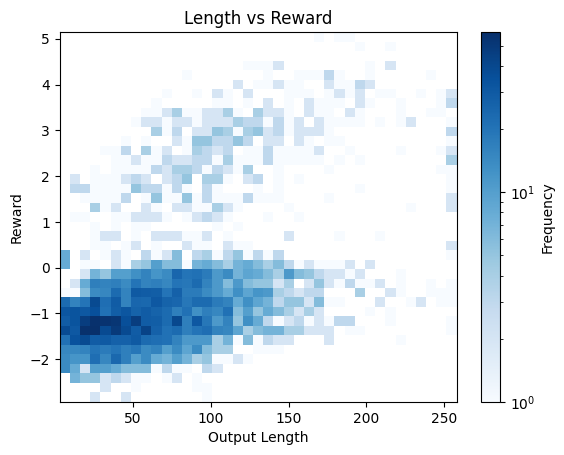

In [15]:
scatter_heatmap(allats, allrws)

In [10]:
sns.heatmap(allrws, allrws, cmap="YlGnBu", vmin=0, cbar=True)

TypeError: heatmap() takes 1 positional argument but 2 positional arguments (and 3 keyword-only arguments) were given

In [8]:
ndfs['wgpt_rewardmodel']

,question,response,answers,atoks,ttoks,rewardmodel,reward
0,Below is an instruction that describes a task....,[Question: How do our bodies produce heat?\n\n...,[ Our body produces heat through metabolism – ...,"[121, 92, 67, 64, 105, 84, 91, 61]","[176, 147, 122, 119, 160, 139, 146, 116]","[-0.2366943359, -0.2218017578, -0.7685546875, ...","[-0.2366943359, -0.2218017578, -0.7685546875, ..."
1,Below is an instruction that describes a task....,"[Question: if brain has no pain receptors, why...",[ Headache pain is caused by changes in the ne...,"[47, 206, 146, 48, 70, 82, 155, 131]","[73, 232, 172, 74, 96, 108, 181, 157]","[-1.1416015625, 0.0635986328, -0.7983398438, -...","[-1.1416015625, 0.0635986328, -0.7983398438, -..."
2,Below is an instruction that describes a task....,[Question: How is it that humans advanced more...,[ It could be argued that human advancement de...,"[121, 110, 150, 134, 106, 65, 129, 135]","[170, 159, 199, 183, 155, 114, 178, 184]","[-0.9721679688, -0.1768798828, 0.1899414062, -...","[-0.9721679688, -0.1768798828, 0.1899414062, -..."
3,Below is an instruction that describes a task....,"[Question: Why do we call herbal water ""Tea""?\...",[ The term “tea” originally referred to any ty...,"[62, 81, 68, 113, 115, 78, 65, 100]","[78, 97, 84, 129, 131, 94, 81, 116]","[-0.865234375, -0.609375, -0.7485351562, -1.06...","[-0.865234375, -0.609375, -0.7485351562, -1.06..."
4,Below is an instruction that describes a task....,[Question: Why do colleges in the United State...,[ The main reason why US college costs so much...,"[155, 159, 106, 128, 91, 97, 131, 133]","[293, 297, 244, 266, 229, 235, 269, 271]","[0.5952148438, 0.6469726562, 0.0066566467, 0.0...","[0.5952148438, 0.6469726562, 0.0066566467, 0.0..."
...,...,...,...,...,...,...,...
794,Below is an instruction that describes a task....,[Question: What happens to tenants/renters if ...,[ If the apartment complex was sold at auction...,"[119, 160, 166, 128, 120, 99, 121, 108]","[189, 230, 236, 198, 190, 169, 191, 178]","[0.1506347656, 0.611328125, 0.2164306641, -0.0...","[0.1506347656, 0.611328125, 0.2164306641, -0.0..."
795,Below is an instruction that describes a task....,[Question: Why is it that whenever I'm nervous...,[ Nervousness can cause you to be more aware o...,"[45, 113, 47, 122, 55, 58, 81, 108]","[74, 142, 76, 151, 84, 87, 110, 137]","[-1.1748046875, -0.4038085938, -1.0234375, 0.1...","[-1.1748046875, -0.4038085938, -1.0234375, 0.1..."
796,Below is an instruction that describes a task....,"[Question: Why did ""soap operas"" always seem t...",[ The reason why soap operas had higher-defini...,"[72, 95, 87, 45, 67, 73, 56, 89]","[97, 120, 112, 70, 92, 98, 81, 114]","[-0.7197265625, -0.3022460938, -0.3037109375, ...","[-0.7197265625, -0.3022460938, -0.3037109375, ..."
797,Below is an instruction that describes a task....,[Question: Why does the reflection of my car i...,[ The reflected image depends on several facto...,"[57, 60, 86, 47, 100, 177, 108, 67]","[88, 91, 117, 78, 131, 208, 139, 98]","[-1.4501953125, -1.4169921875, -1.03515625, -1...","[-1.4501953125, -1.4169921875, -1.03515625, -1..."


In [21]:
# shuffdfs = load_all_rmdfs("../trl-general/rmshuffs/")
# rmdfs = load_all_rmdfs("../trl-general/rmouts/")
# moredfs = load_all_rmdfs("../trl-general/morermouts/")
# attdfs = load_all_hackdfs("../trl-general/fullattacks/")

In [8]:
ind = 10
r = attdfs['wgptda'].iloc[ind]
highlight_differences(r['origseq'], r['bestseqs'][-1])

In [9]:
kmap = {
    'stackrandaug':'stack_rewardrandaug',
    'stackda':'stack_rewardda',
    'stackmix':'stack_rewardmixed',
    'wgptda':'wgpt_rewardrandda',
    'wgptorig':'wgpt_rewardmodel',
    'stacksanity':'stack_rewardsanity'
}

In [18]:
rmdfs.keys()

dict_keys(['stack_shuffrewardda', 'stack_shuffrewardmixed', 'wgpt_shuffrewardmodel', 'wgpt_shuffrewardrandda', 'stack_shuffrewardsanity', 'stack_shuffrewardrandaug'])

In [8]:
keyval = "wgpt_rewardmodel"

In [9]:
for k in attdfs.keys():
    norm = stdev(getfulldist(rmdfs[kmap[k]].reward))
    print(k)
    # print(attdfs[k]['diff'].mean())
    print(norm)

NameError: name 'attdfs' is not defined

In [18]:
for k in shuffdfs.keys():
    tmpa = pd.DataFrame({
        'or':getfulldist(rmdfs[k.replace("shuff", "")].reward),
        'shuff':getfulldist(shuffdfs[k].reward),
    })
    norm = stdev(list(tmpa['or']))
    print(k)
    # print((tmpa['or']-tmpa['shuff']).abs().mean()/norm)
    print(norm)
    #print(spearmanr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    #print(kendalltau(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))v

stack_shuffrewardrandaug
1.144137052695234
stack_shuffrewardsanity
0.7120275705076311
stack_shuffrewardmixed
0.9171077907658536
wgpt_shuffrewardmodel
0.512840646944082
wgpt_shuffrewardrandda
0.35258641598335
stack_shuffrewardda
0.9241051543405661


In [8]:
rmdfs = ndfs

In [9]:
# get spearman and pearson corrs per batch
for k in rmdfs.keys():
    print(k)
    keyval = k
    sps = [getcorr(r, True) for _, r in rmdfs[k].iterrows()]
    #kts = [getcorr(r, False) for _, r in rmdfs[k].iterrows()]
    print(mean([s for s in sps if not math.isnan(s)]))
    #print(mean([s for s in kts if not math.isnan(s)]))
    #print(spearmanr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    #print(kendalltau(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))v

wgpt_harmrm
-0.4193549101724434
SignificanceResult(statistic=-0.45845874523454416, pvalue=3.069305153520637e-243)


In [15]:
for k in rmdfs.keys():
    print(k)
    keyval = k
    norm = stdev(getfulldist(rmdfs[k].reward))
    # results = [(max(s)-median(s))/norm for s in rmdfs[k].reward]
    results = [(stdev(s))/norm for s in rmdfs[k].reward]
    #rouges = [rpaircorr(r) for _, r in rmdfs[k].iterrows()]
    print(mean([r for r in results if not math.isnan(r)]))
    #print(mean([r for r in rouges if not math.isnan(r)]))


wgpt_rlcdrightonly2
0.5278366012032217
wgpt_apfrandcarto
0.40876453165332205
wgpt_apfgoodcut2
0.5097901100133093
wgpt_wgptgoodcut2
0.35102761003588195
wgpt_rlcdmidcut2
0.5272736142497723
wgpt_wgptbothcut2
0.5617339277810276
wgpt_rlcdnormal
0.5463073222251673
wgpt_apfnormal
0.32908136844492175
wgpt_rlcdbothcut2
0.49508388214928417
wgpt_wgptrandcarto
0.40042503435712756
wgpt_rlcdleftonly2
0.5236283439381603
wgpt_rlcdgoodcut2
0.5307293988443437


(array([  94.,  482., 1565., 1944., 1199.,  667.,  252.,  103.,   47.,
          39.]),
 array([  2. ,  27.6,  53.2,  78.8, 104.4, 130. , 155.6, 181.2, 206.8,
        232.4, 258. ]),
 <BarContainer object of 10 artists>)

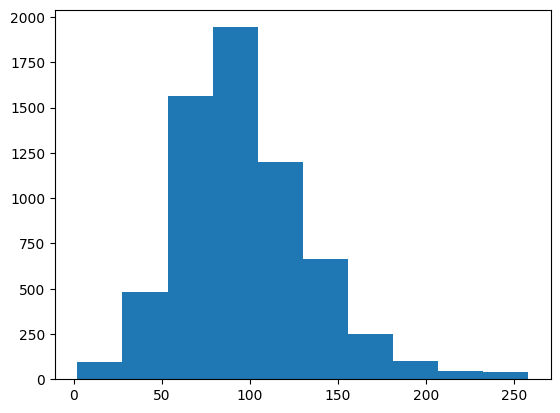

In [91]:
plt.hist(getfulldist(rmdfs[keyval].atoks))

In [19]:
for k in rmdfs.keys():
    print(k)
    keyval = k
    print(pearsonr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    #print(spearmanr(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))
    # print(kendalltau(getfulldist(rmdfs[keyval].reward), getfulldist(rmdfs[keyval].atoks)))

stack_shuffrewardda
PearsonRResult(statistic=0.19360208722151298, pvalue=9.304967998824017e-55)
stack_shuffrewardmixed
PearsonRResult(statistic=-0.02117794872229203, pvalue=0.0912595806538025)
wgpt_shuffrewardmodel
PearsonRResult(statistic=0.6862010148602476, pvalue=0.0)
wgpt_shuffrewardrandda
PearsonRResult(statistic=0.24138648827280548, pvalue=2.0606832492580663e-85)
stack_shuffrewardsanity
PearsonRResult(statistic=0.09725125541677739, pvalue=7.685828382720676e-15)
stack_shuffrewardrandaug
PearsonRResult(statistic=0.07587236737730434, pvalue=1.3753695111232166e-09)


In [ ]:
rmdfs = load_all_rmdfs("../trl-general/fullattacks/")

In [ ]:
print(mean([stdev(s) for s in rmdfs[keyval].reward])/stdev(getfulldist(rmdfs[keyval].reward)))
plt.hist([stdev(s) for s in rmdfs[keyval].reward])

In [ ]:
wgptorigrm = load_rm("../tr")

In [11]:
allresps = getfulldist(stackouts.response)

In [16]:
allscos = progress_rm(allresps[:100], stackorigrm, kwargs)

 57%|██████████████████████████████████████████████████████████████████████████████▊                                                           | 4/7 [00:32<00:27,  9.12s/it]/home/prasann/miniconda3/envs/rlenv/lib/python3.9/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:49<00:00,  7.09s/it]


In [ ]:
compdist([a[0]['score'] for a in allscos], 8)

(array([ 229.,  526.,  818.,  767.,  656.,  560.,  466.,  340.,  289.,
        1709.]),
 array([  4. ,  30.2,  56.4,  82.6, 108.8, 135. , 161.2, 187.4, 213.6,
        239.8, 266. ]),
 <BarContainer object of 10 artists>)

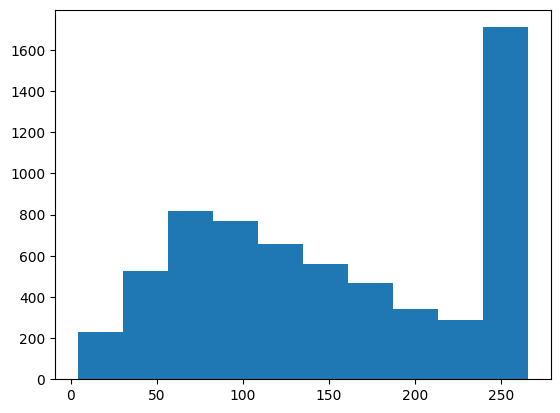

In [8]:
plt.hist(getfulldist(stackouts.atoks))